# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [ ]:
# Install keras
# !pip install -U keras

In [2]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [4]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# What do these sequences look like?
X_train_seq[0]

[425,
 1639,
 1997,
 425,
 273,
 75,
 3854,
 8,
 1640,
 4,
 292,
 140,
 3855,
 6,
 235,
 9,
 5,
 76,
 140,
 1269,
 6,
 1641,
 122,
 24,
 3856,
 2,
 2559,
 14,
 243,
 936]

In [7]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [8]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  425, 1639,
       1997,  425,  273,   75, 3854,    8, 1640,    4,  292,  140, 3855,
          6,  235,    9,    5,   76,  140, 1269,    6, 1641,  122,   24,
       3856,    2, 2559,   14,  243,  936])

### Build Model

In [9]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [10]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          254368    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 263777 (1.01 MB)
Trainable params: 263777 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [12]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 6s 23ms/step - loss: 0.2583 - accuracy: 0.9235 - precision_m: 0.5439 - recall_m: 0.4453 - val_loss: 0.0673 - val_accuracy: 0.9812 - val_precision_m: 0.9871 - val_recall_m: 0.8548
Epoch 2/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0345 - accuracy: 0.9904 - precision_m: 0.9859 - recall_m: 0.9456 - val_loss: 0.0590 - val_accuracy: 0.9857 - val_precision_m: 0.9871 - val_recall_m: 0.8962
Epoch 3/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0111 - accuracy: 0.9975 - precision_m: 0.9596 - recall_m: 0.9532 - val_loss: 0.0601 - val_accuracy: 0.9830 - val_precision_m: 0.9671 - val_recall_m: 0.9033
Epoch 4/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0046 - accuracy: 0.9989 - precision_m: 0.9905 - recall_m: 0.9872 - val_loss: 0.0784 - val_accuracy: 0.9812 - val_precision_m: 0.9633 - val_recall_m: 0.8890
Epoch 5/10
140/140 [==============================] - 3s 20ms/step -

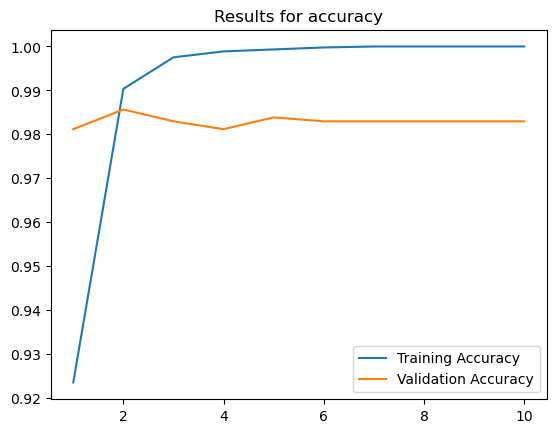

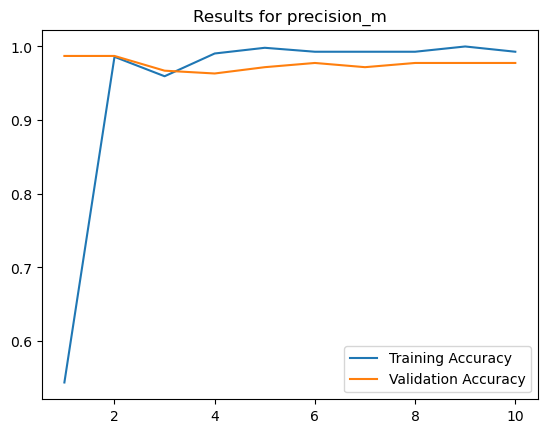

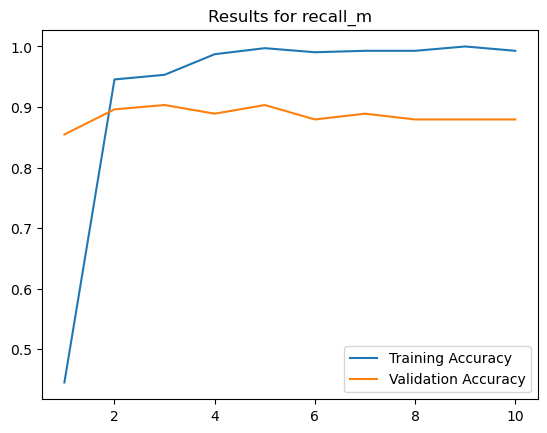

In [13]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()